We clear the outputs of the data set in this notebook due to non-disclosure agreements.

Instead, the redacted data set is published but may not lead to the same results as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import pandas as pd
pd.set_option('display.max_columns', 500)

import seaborn as sns
sns.set_theme(font_scale=1)

import os
from pathlib import Path
from tqdm import tqdm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import pickle
import joblib

import shap
import pingouin as pg

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# load data

In [2]:
df_filtered_risidual = pd.read_pickle('output/processed_dataset/bom_tc600_cleaned_encoded_filtered_residual.pkl')
df_filtered_risidual

,No. Cells per module,Wafer thickness (μm),Number of busbars,Cell height (mm),Cell width (mm),Front Encaps thickness (mm),Rear Encaps thickness (mm),Glass Width (mm),Glass Length (mm),Glass Thickness (mm),Backsheet Thickness (mm),Maximum temperature tolerance (°C),Frame Thickness (mm),Cell Interconnect Width (mm),Cell Interconnect Thickness (mm),String Interconnect Width (mm),String Interconnect Thickness (mm),Module Aspect Ratio,Module Area (mm2),Mono or Multi_Multi,Front Encaps Type_EVA,Front Encaps Type_POE,Front Encaps Type_Silicone,TC 600,Back Glass Thickness (mm)
1,72.0,179.0,3.0,156.000,156.00,0.45,0.45,985.0,1949.0,4.0,0.3500,152.6,40.0,1.44,0.250,6.0,0.350,1.978680,1919765.00,1.0,1.0,0.0,0.0,2.600000,0.0
2,60.0,177.0,3.0,156.000,156.00,0.46,0.47,908.8,1616.2,3.2,0.3152,138.0,36.4,3.70,0.248,5.4,0.328,1.778389,1468802.56,1.0,1.0,0.0,0.0,3.350000,0.0
3,192.0,175.0,6.0,95.002,158.80,0.30,0.50,920.0,1913.2,3.2,0.3236,139.0,38.0,3.10,0.296,4.8,0.380,2.079565,1760144.00,1.0,1.0,0.0,0.0,1.544790,0.0
4,72.0,175.0,3.0,164.800,156.00,0.45,0.47,988.4,1962.0,3.2,0.3092,123.0,38.0,1.56,0.216,6.0,0.276,1.985026,1939240.80,1.0,1.0,0.0,0.0,2.279859,0.0
5,60.0,175.0,3.0,156.150,156.15,0.45,0.48,987.6,1679.8,3.2,0.3130,135.0,35.4,3.64,0.250,5.6,0.272,1.700891,1658970.48,0.0,1.0,0.0,0.0,0.111273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,144.0,175.0,10.0,91.000,182.00,0.65,0.70,1128.0,2267.0,3.2,0.3260,159.0,40.0,0.35,0.350,4.0,0.400,2.009752,2557176.00,0.0,1.0,0.0,0.0,1.060000,0.0
436,144.0,175.0,10.0,91.000,182.00,0.65,0.70,1128.0,2267.0,3.2,0.3260,159.0,40.0,0.35,0.350,4.0,0.400,2.009752,2557176.00,0.0,1.0,0.0,0.0,1.030000,0.0
442,120.0,165.0,12.0,80.800,161.70,0.50,0.45,1024.0,1765.0,3.2,0.3700,180.0,32.0,0.26,0.260,6.0,0.300,1.723633,1807360.00,0.0,1.0,0.0,0.0,1.150000,0.0
443,60.0,180.0,12.0,166.000,166.00,0.55,0.55,1036.0,1734.0,2.8,0.3000,110.0,40.0,0.37,0.370,6.0,0.380,1.673745,1796424.00,0.0,1.0,0.0,0.0,3.340000,0.0


((200, 24), (51, 24))

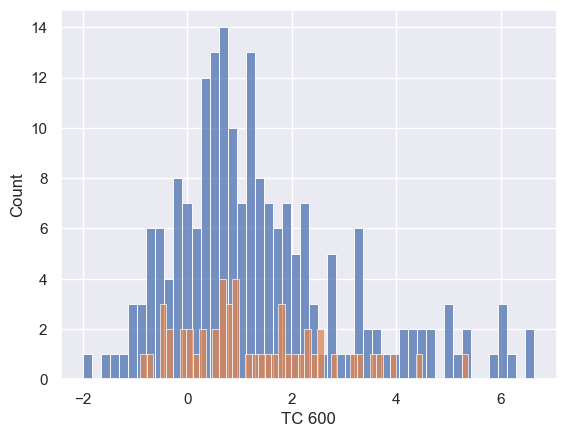

In [3]:
X_train_filtered_residual, X_test_filtered_residual, y_train_filtered_residual, y_test_filtered_residual = train_test_split(
    df_filtered_risidual.drop(columns=['TC 600']), df_filtered_risidual['TC 600'], test_size=0.2, random_state=45)

# histplot of y_train and y_test
sns.histplot(y_train_filtered_residual, bins=50)
sns.histplot(y_test_filtered_residual, bins=50)
X_train_filtered_residual.shape, X_test_filtered_residual.shape

# train model

In [4]:
from bom_tc_pkg import train_lasso, train_ridge, train_rf, train_xgboost, train_svr
from bom_tc_pkg import extract_metrics, plot_train_test_score

In [ ]:
record_filtered_residual = {
    'rf': {},
    'ridge': {},
    'lasso': {},
    'xgboost': {},
    'svr': {}
}

rf_filtered_residual = train_rf(X_train_filtered_residual, y_train_filtered_residual, X_test_filtered_residual, y_test_filtered_residual, record_filtered_residual, model_name='rf')
ridge_filtered_residual = train_ridge(X_train_filtered_residual, y_train_filtered_residual, X_test_filtered_residual, y_test_filtered_residual, record_filtered_residual, model_name='ridge')
svr_filtered_residual = train_svr(X_train_filtered_residual, y_train_filtered_residual, X_test_filtered_residual, y_test_filtered_residual, record_filtered_residual, model_name='svr')
lasso_filtered_residual = train_lasso(X_train_filtered_residual, y_train_filtered_residual, X_test_filtered_residual, y_test_filtered_residual, record_filtered_residual, model_name='lasso')

In [6]:
xgboost_filtered_residual = train_xgboost(X_train_filtered_residual, y_train_filtered_residual, X_test_filtered_residual, y_test_filtered_residual, record_filtered_residual, model_name='xgboost')

In [7]:
metrics_filtered_residual_df = extract_metrics(record_filtered_residual)
# metrics_filtered_residual_df

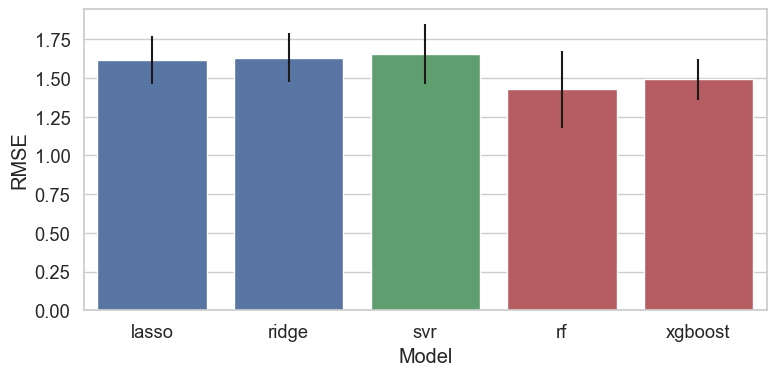

In [8]:
plt.figure(figsize=(8, 4))
sns.set_theme(font_scale=1.2 ,style="whitegrid")
df = metrics_filtered_residual_df.query('train_test == "train" & model != "ols"')
df = df.sort_values(by='model', key=lambda x: x.map({model:i for i, model in enumerate(['lasso', 'ridge', 'svr', 'rf', 'xgboost'])}))
sns.barplot(data=df, x='model', y='cv_rmse_mean', yerr=df['cv_rmse_std'], palette=['#4c72b0', '#4c72b0', '#55a868', '#c44e52', '#c44e52'])

plt.xlabel('Model')
plt.ylabel('RMSE')

plt.tight_layout()

<Figure size 600x600 with 0 Axes>

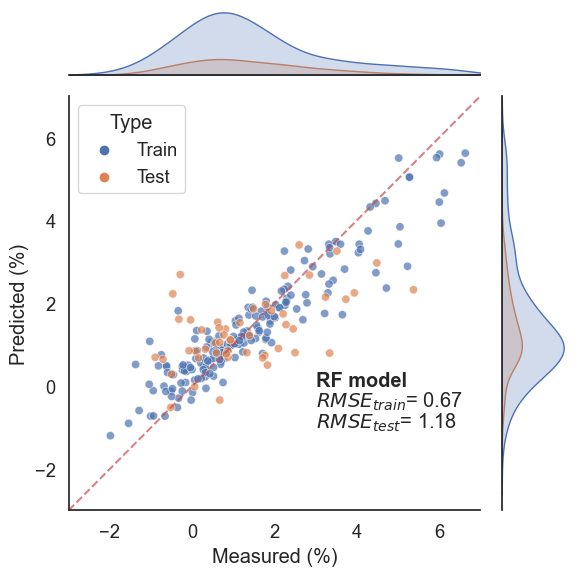

In [9]:
# sns.set(font_scale=1)
sns.set_theme(font_scale=1.2 ,style="white")
model = 'rf'
y_train_pred, y_test_pred = record_filtered_residual[model]['y_train_pred'], record_filtered_residual[model]['y_test_pred']
rmse_train, rmse_test = record_filtered_residual[model]['rmse_train'], record_filtered_residual[model]['rmse_test']

temp = {
    'Measured(%)': y_train_filtered_residual.to_list() + y_test_filtered_residual.to_list(),
    'Predicted(%)': list(y_train_pred) + list(y_test_pred),
    'Type': ['Train'] * len(y_train_filtered_residual) + ['Test'] * len(y_test_filtered_residual)
}

temp = pd.DataFrame(temp)
plt.figure(figsize=(6, 6))
sns.jointplot(data=temp, x='Measured(%)', y='Predicted(%)', hue='Type', xlim=(-3, 7), ylim=(-3,7), alpha=0.7)
plt.plot(np.linspace(-3, 7, 20), np.linspace(-3, 7, 20), c='r', linestyle='--', alpha=0.7)

# bold
plt.text(3, 0, f'RF model', fontweight='bold')
plt.text(3, -0.5, r'$RMSE_{train}$' + '= {:.2f}'.format(rmse_train))
plt.text(3, -1, r'$RMSE_{test}$' + '= {:.2f}'.format(rmse_test))

plt.xlabel('Measured (%)')
plt.ylabel('Predicted (%)')
plt.tight_layout()

# SHAP

train the RF model on both training and testing set because the goal of this project is to interpret the whole dataset

In [11]:
X_concat = pd.concat([X_train_filtered_residual, X_test_filtered_residual], axis=0)
X_concat.rename(columns={'Mono or Multi_Multi': 'Si Type (Poly=1)'}, inplace=True)

y_concat = pd.concat([y_train_filtered_residual, y_test_filtered_residual], axis=0)

rf_filtered_residual.fit(X_concat, y_concat)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=15,
                      random_state=12)

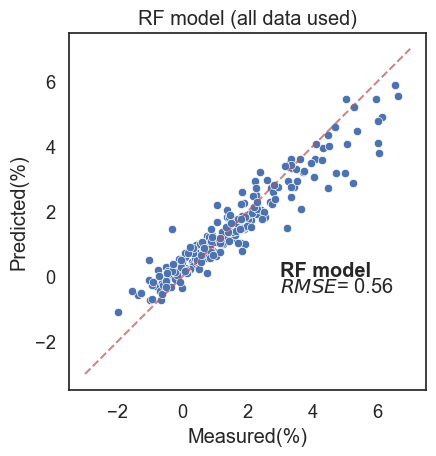

In [12]:
y_pred = rf_filtered_residual.predict(X_concat)
rmse = np.sqrt(mean_squared_error(y_concat, y_pred))

sns.scatterplot(x=y_concat, y=y_pred)
plt.plot(np.linspace(-3, 7, 20), np.linspace(-3, 7, 20), c='r', linestyle='--', alpha=0.7)
plt.xlabel('Measured(%)')
plt.ylabel('Predicted(%)')
plt.text(3, 0, f'RF model', fontweight='bold')
plt.text(3, -0.5, r'$RMSE$' + '= {:.2f}'.format(rmse))
plt.title('RF model (all data used)')
# make axis equal
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

## SHAP values

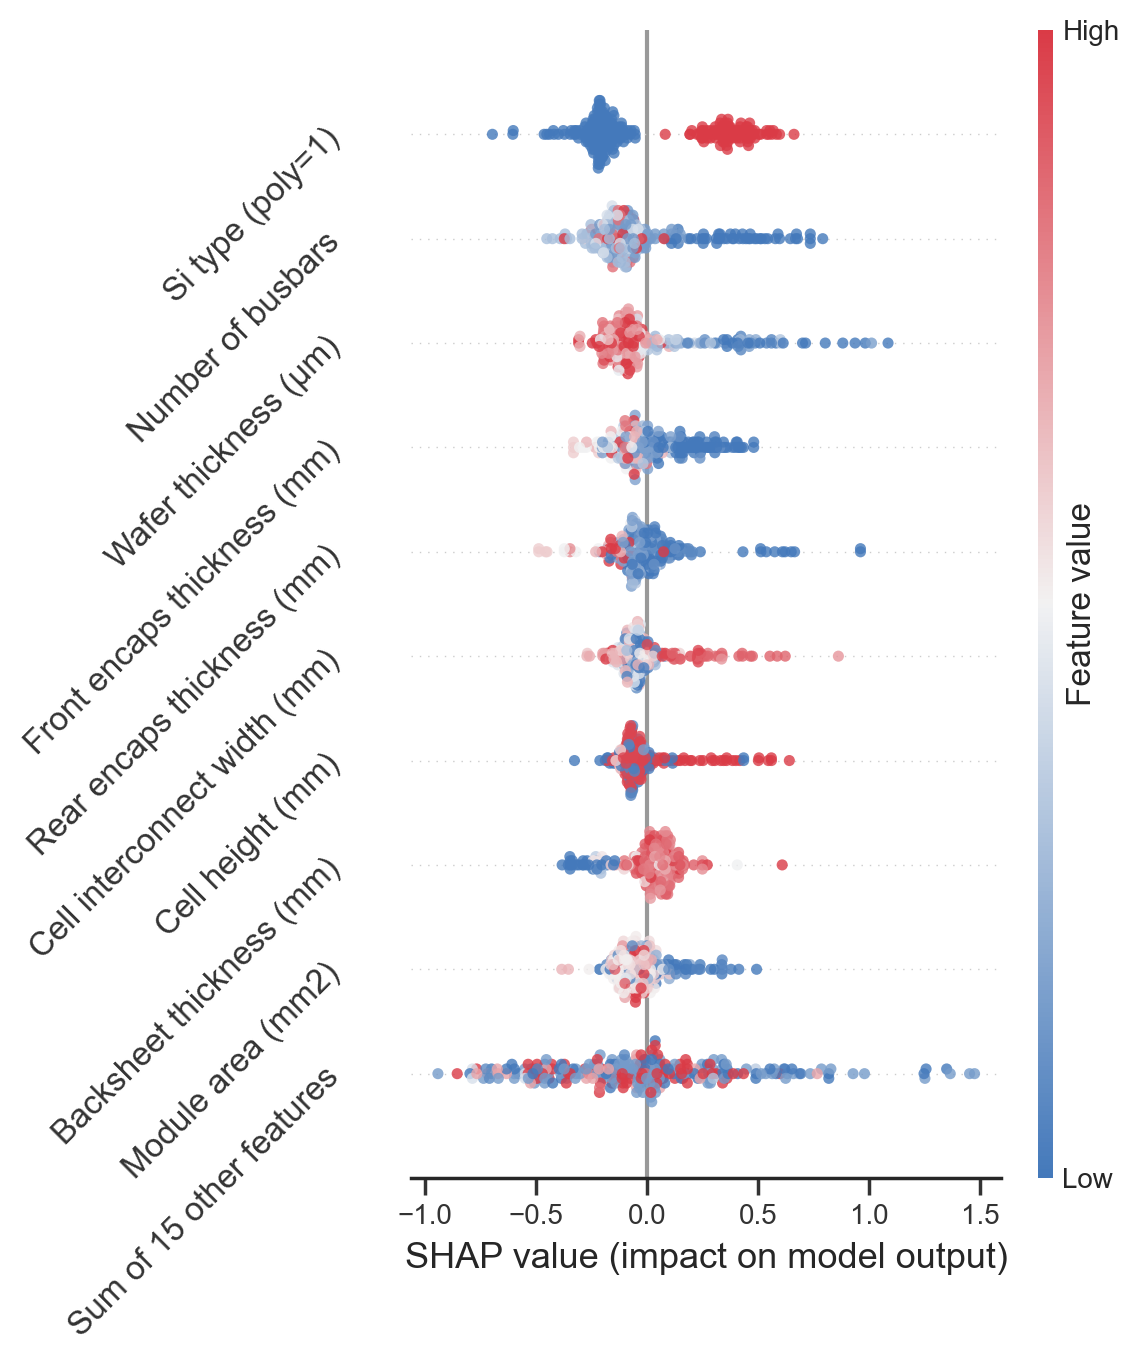

In [22]:
X_concat.columns = X_concat.columns.str.capitalize()
sns.set_theme(font_scale=1,style="white")
explainer = shap.Explainer(rf_filtered_residual)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(X_concat)

shap.plots.beeswarm(shap_values, max_display=10, show=False, plot_size=(6, 7), 
                    color=sns.diverging_palette(250, 10, center='light', as_cmap=True), alpha=0.8)
plt.yticks(fontsize=12, rotation=45)


plt.xticks(fontsize=10)
# change colorbar label size and make it closer to colorbar
plt.gcf().axes[-1].yaxis.label.set_size(12)
plt.gcf().axes[-1].yaxis.set_label_coords(2, 0.5)

# cahnge colorbar tick size
plt.gcf().axes[-1].tick_params(labelsize=10)

plt.tight_layout()

## bootstrapping

In [23]:
from tqdm import tqdm

shap_importance_boot = []
for i in tqdm(range(1000)):
    X_boot = X_concat.sample(frac=1, replace=True)
    shap_values_boot = explainer(X_boot)
    shap_importance_boot.append(np.abs(shap_values_boot.values).mean(axis=0))

importance_df = pd.DataFrame(np.array(shap_importance_boot), columns=X_concat.columns.str.capitalize())
importance_df

100%|██████████| 1000/1000 [01:30<00:00, 11.03it/s]


,No. cells per module,Wafer thickness (μm),Number of busbars,Cell height (mm),Cell width (mm),Front encaps thickness (mm),Rear encaps thickness (mm),Glass width (mm),Glass length (mm),Glass thickness (mm),Backsheet thickness (mm),Maximum temperature tolerance (°c),Frame thickness (mm),Cell interconnect width (mm),Cell interconnect thickness (mm),String interconnect width (mm),String interconnect thickness (mm),Module aspect ratio,Module area (mm2),Si type (poly=1),Front encaps type_eva,Front encaps type_poe,Front encaps type_silicone,Back glass thickness (mm)
0,0.090325,0.177400,0.189511,0.101584,0.057396,0.128655,0.111922,0.087784,0.042491,0.020678,0.098854,0.039710,0.033188,0.099792,0.057145,0.058737,0.044722,0.061950,0.093804,0.270849,0.006466,0.035699,0.000200,0.002772
1,0.087582,0.187882,0.215504,0.101682,0.057838,0.137352,0.101397,0.082121,0.039251,0.023341,0.094963,0.040162,0.030732,0.107997,0.058287,0.059415,0.048903,0.066818,0.096618,0.287741,0.005900,0.038299,0.000244,0.002846
2,0.085094,0.175807,0.199279,0.096884,0.052913,0.130158,0.100429,0.078214,0.042265,0.024887,0.106387,0.036965,0.028349,0.108819,0.062635,0.061709,0.044329,0.062235,0.089001,0.274970,0.006869,0.034269,0.000200,0.003489
3,0.090640,0.201463,0.172872,0.097725,0.061581,0.134924,0.126746,0.082419,0.041474,0.024819,0.095803,0.038617,0.035924,0.087566,0.061316,0.056160,0.046900,0.059661,0.101184,0.279203,0.005678,0.034296,0.000196,0.003177
4,0.097686,0.178635,0.214515,0.113044,0.056395,0.136841,0.098631,0.080410,0.034158,0.022074,0.088595,0.037455,0.026462,0.114743,0.059685,0.067807,0.048584,0.068845,0.090388,0.281159,0.005717,0.032994,0.000179,0.002670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.094824,0.158963,0.174359,0.096668,0.059565,0.129989,0.112142,0.090362,0.041345,0.023384,0.102785,0.035781,0.028680,0.089711,0.058009,0.059911,0.042486,0.055482,0.086189,0.268924,0.005699,0.038414,0.000243,0.002847
996,0.091834,0.192156,0.195134,0.105824,0.058158,0.139121,0.121065,0.079715,0.043565,0.023898,0.102828,0.037551,0.030031,0.102552,0.058535,0.061064,0.049285,0.054975,0.088090,0.271847,0.006423,0.033701,0.000205,0.002966
997,0.082836,0.196514,0.182775,0.107363,0.056939,0.127890,0.123168,0.090494,0.045882,0.023830,0.099611,0.039474,0.028957,0.100769,0.067030,0.061367,0.045210,0.059714,0.090946,0.276931,0.006903,0.034383,0.000247,0.003077
998,0.087516,0.190723,0.185104,0.088845,0.055313,0.137747,0.132307,0.075897,0.034939,0.024412,0.097977,0.038746,0.033340,0.101367,0.062496,0.056675,0.038762,0.054849,0.095286,0.287161,0.005213,0.037892,0.000226,0.003101


In [46]:
importance_df.to_pickle('output/processed_dataset/shap_importance.pkl')

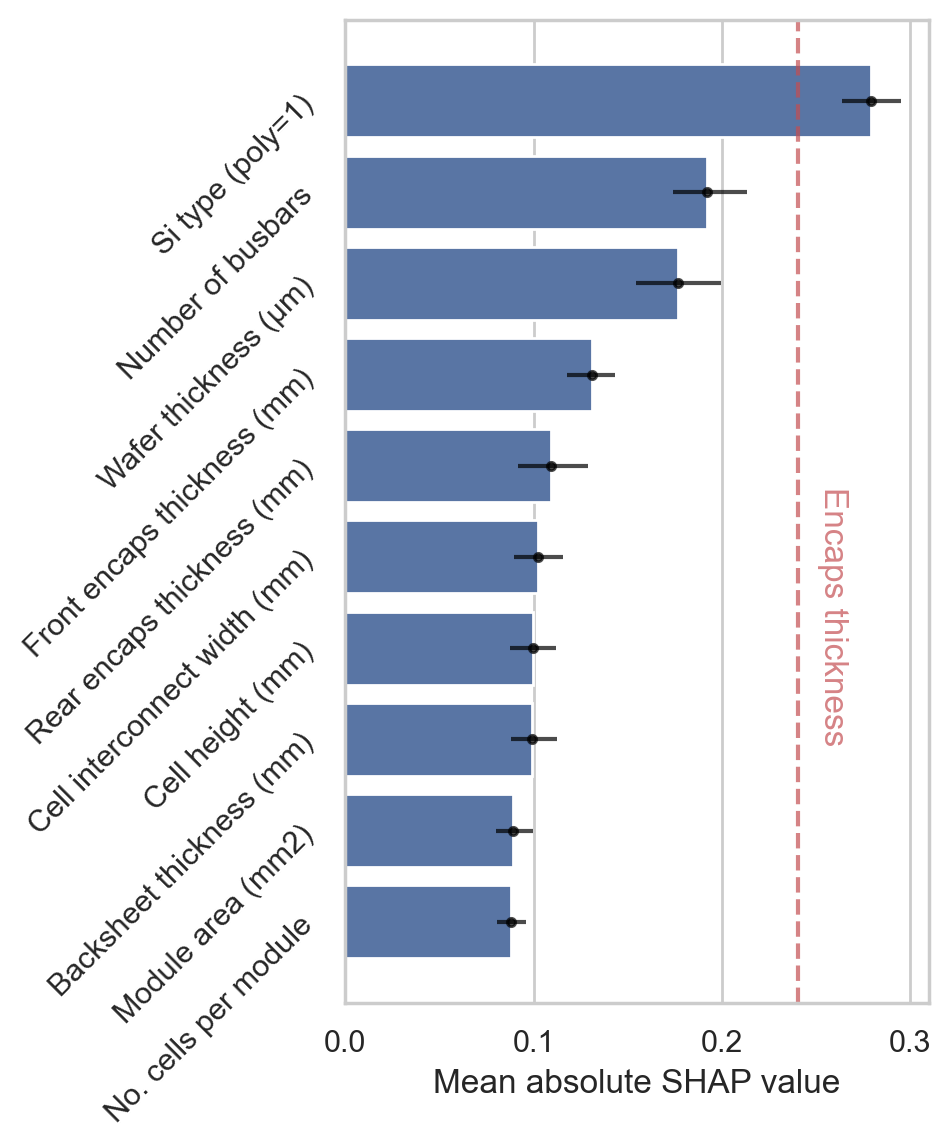

In [24]:
importance_all_data = pd.Series(np.abs(shap_values.values).mean(axis=0), index=X_concat.columns.str.capitalize())
importance_encaps_thickness_all_data = importance_all_data['Front encaps thickness (mm)'] + importance_all_data['Rear encaps thickness (mm)']

sns.set_theme(font_scale=1.2 ,style="whitegrid")
ci_low = importance_df.quantile(0.025, axis=0)
ci_high = importance_df.quantile(0.975, axis=0)

# rank by importance_mean
# only plot the top 10 features
importance_all_data = importance_all_data.sort_values(ascending=False)[:10]
ci_low = ci_low[importance_all_data.index]
ci_high = ci_high[importance_all_data.index]

plt.figure(figsize=(5,6))

# barplot of importance_all_data, show the lower and upper bound of 95% confidence interval for each feature
sns.barplot(data=importance_all_data.reset_index(), x=0, y='index', color='b')
plt.errorbar(importance_all_data, importance_all_data.index, xerr=[importance_all_data - ci_low, ci_high - importance_all_data], color='black', fmt='.', alpha=0.7)
plt.yticks(fontsize=11, rotation=45)

plt.xticks(fontsize=11)
plt.axvline(importance_encaps_thickness_all_data, c='r', linestyle='--', alpha=0.7)

plt.ylabel('')
plt.xlabel('Mean absolute SHAP value', fontsize=12)
# rotated 'Front and Rear Encaps thickness' label
plt.text(importance_encaps_thickness_all_data+0.01, 7, 
         'Encaps thickness', color='r', alpha=0.7, fontsize=12, rotation=270)

plt.tight_layout()

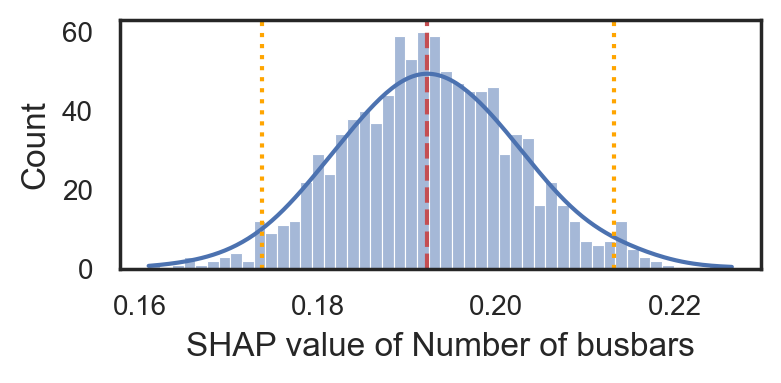

In [25]:
plt.figure(figsize=(4, 2))
col = 'Number of busbars'#'Front Encaps thickness (mm)'
sns.set_theme(font_scale=1,style="white")
plt.rcParams.update({'font.size': 10,
                     'axes.labelsize': 12,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                     'legend.fontsize': 10})
# increase smoothness of kde
sns.histplot(importance_df[col], bins=50, kde=True, kde_kws={'bw_adjust': 1.8})
plt.axvline(x=importance_all_data[col], color='r', linestyle='--')
plt.axvline(x=importance_df[col].quantile(0.025), color='orange', linestyle=':')
plt.axvline(x=importance_df[col].quantile(0.975), color='orange', linestyle=':')

plt.xlabel(f'SHAP value of {col}')
plt.ylabel('Count')

plt.tight_layout()

## feature depence plot

In [27]:
from bom_tc_pkg import reg_rugplot

In [52]:
shap_values[:, 'Front encaps thickness (mm)'].values.shape

(251,)

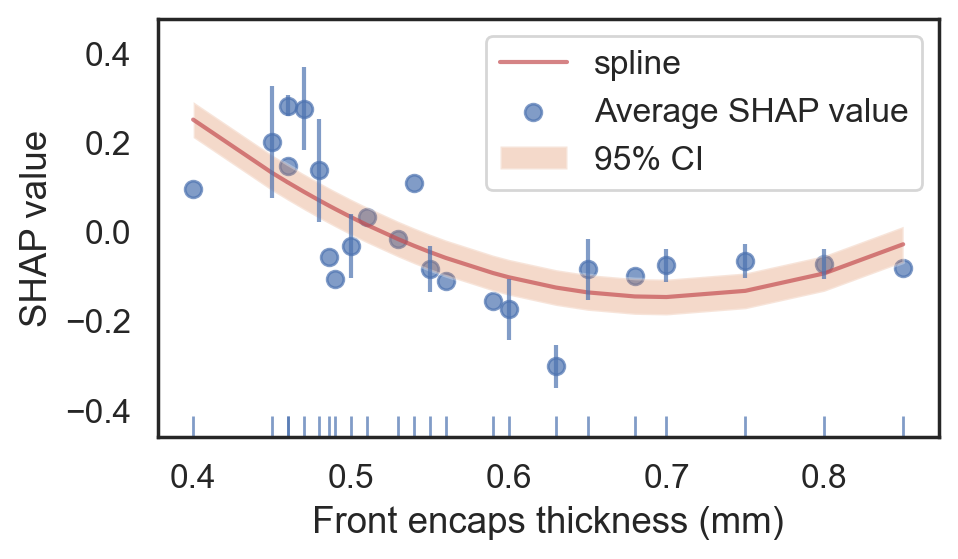

In [42]:
sns.set_theme(font_scale=1.1,style="white")
reg_rugplot(shap_values, 'Front encaps thickness (mm)', smooth=1, xlim=(0.4, 1), figsize=(5, 3))
# plt.legend([])

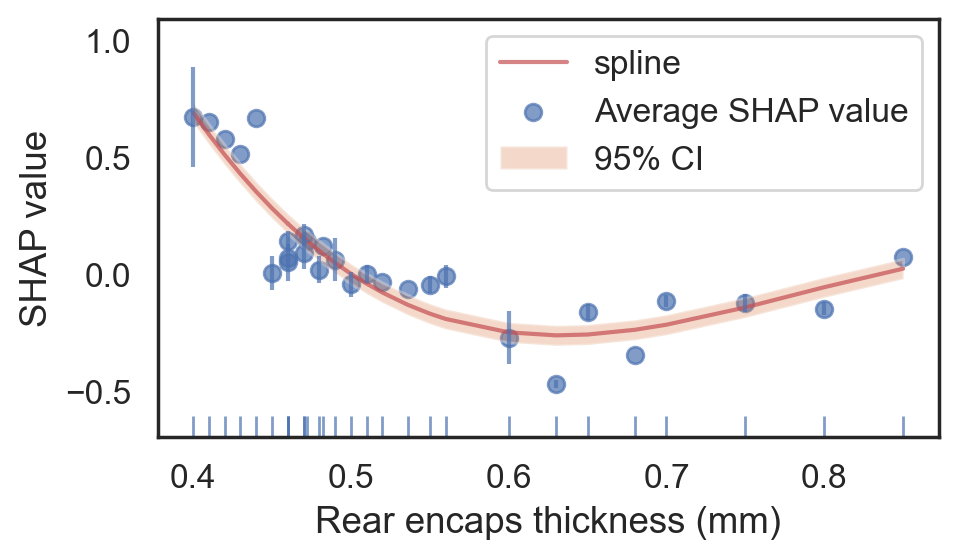

In [43]:
reg_rugplot(shap_values, 'Rear encaps thickness (mm)', smooth=1, xlim=(0.3, 2), figsize=(5, 3))
# plt.legend([])

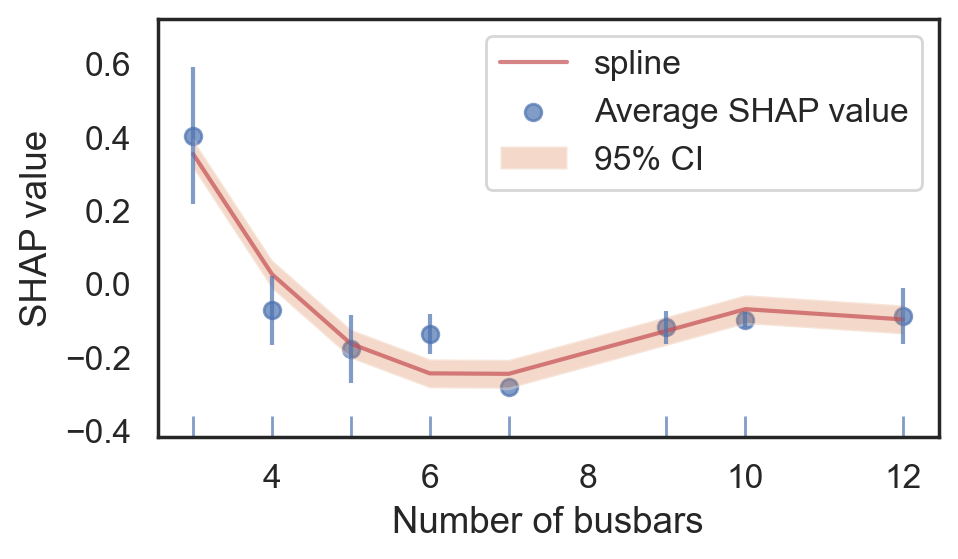

In [44]:
reg_rugplot(shap_values, 'Number of busbars', smooth=1, xlim=(0, 15), figsize=(5, 3))

# plt.legend([])

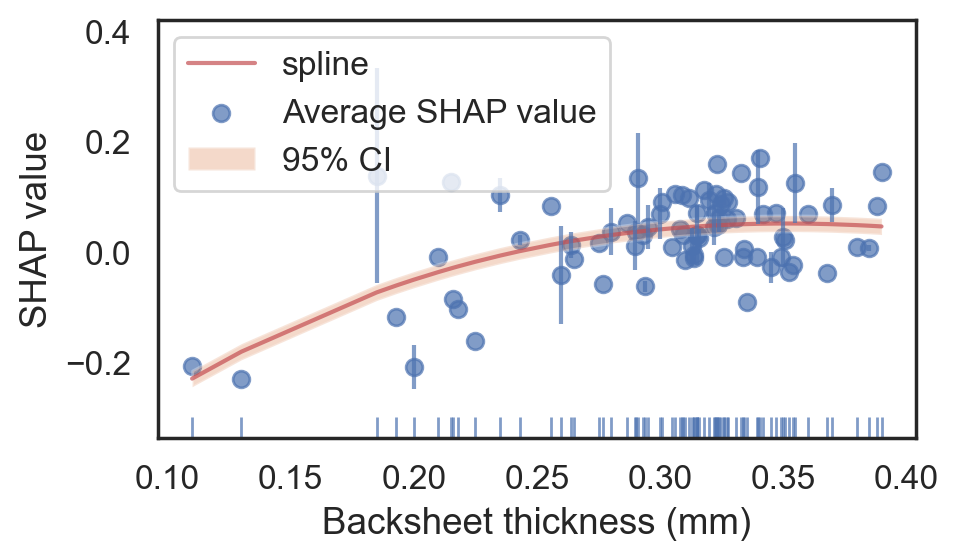

In [45]:
reg_rugplot(shap_values, 'Backsheet thickness (mm)', smooth=1, xlim=(0.1, 0.4), figsize=(5, 3))

plt.legend(loc='upper left')
# plt.legend([])

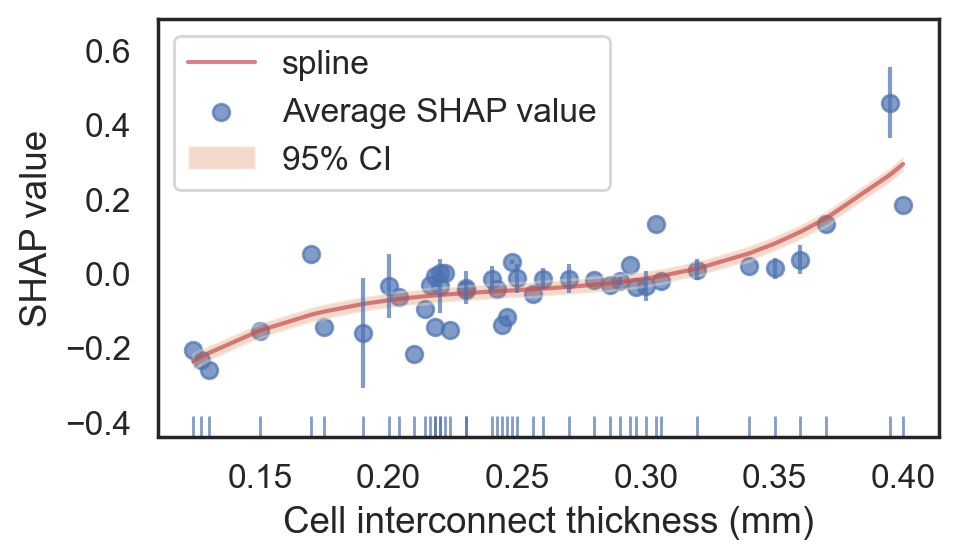

In [40]:
reg_rugplot(shap_values, 'Cell interconnect thickness (mm)', smooth=1, figsize=(5, 3), xlim=(0, 0.5))

# plt.legend([], loc='upper left')

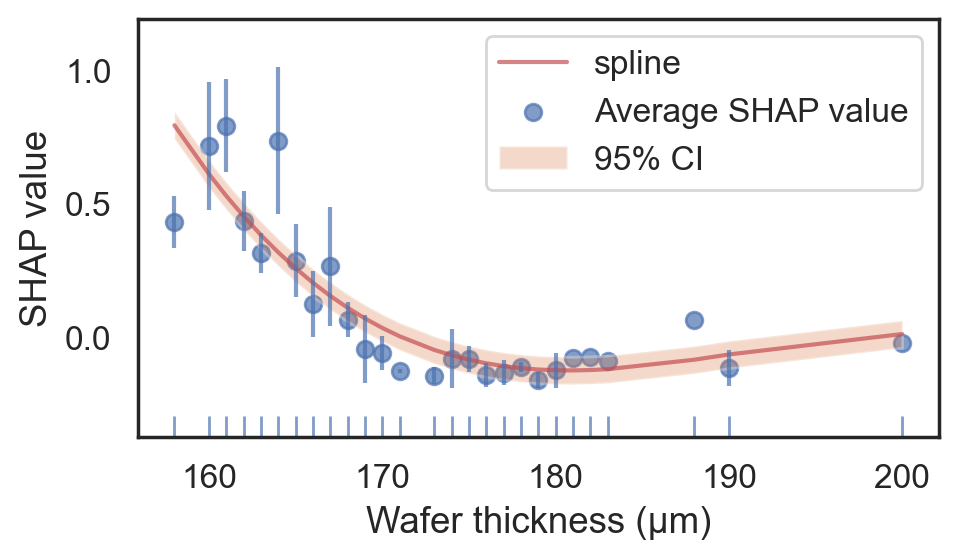

In [41]:
reg_rugplot(shap_values, 'Wafer thickness (μm)', smooth=1, xlim=(155, 200), figsize=(5, 3))
# plt.legend([])